# Iteration 30: streamlit (3)

## Plain English Summary

The last step in creating a `streamlit` interface adds contextual and citation information.

The full streamlit code listing is available in runnable form in  [29_stroke_rehab_interface_s2.py](29_stroke_rehab_interface_s2.py)

## Notebook imports

In [1]:
import math
import statistics
from sim_tools.distributions import Lognormal

## LLM Prompt <a class="anchor" id="llm_prompt"></a>

::::{admonition} LLM Prompt
:::{include} ../04_prompts_stage1/inputs/30_iteration.md
:::
::::

## Diff of notebooks. <a class="anchor" id="diff"></a>

N/A

## Date and time of input to LLM

> 1245 27th July 2024

## Observations on the LLM Output

* This was a simple change and it was successful.

## Sources reported by the LLM

* None reported at time of generation.

## Code carried over

* `normal_moments_from_lognormal` - a function for converting moments of a lognormal to underlying normal
*  `audit_acute_occupancy` - code to observe the ASU occupancy at specified time intervals.
*  `calculate_occupancy_frequencies` - calculate relative frequencies of occupancy observations
*  `occupancy_plot` - show occupancy as a bar chart.
*  `calculate_prob_delay`
*  `prob_delay_plot`
*  `AcuteStrokeUnit`
*  `RehabilitationUnit`
*  `single_run` - code that runs the full model ASU+REHAB
*  `multiple_replications`
*  `combine_pdelay_results`
*  `combine_occup_results`
*  `summary_table`
*  `Experiment`

## Model code <a class="anchor" id="model_code"></a>

### Imports

In [3]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### lognormal function

In [4]:
def lognormal_to_normal(mean, std):
    """
    Convert lognormal moments to normal moments.
    
    Parameters:
    mean (float): Mean of the lognormal distribution.
    std (float): Standard deviation of the lognormal distribution.
    
    Returns:
    tuple: (mean, std) of the corresponding normal distribution.
    """
    normal_mean = np.log(mean ** 2 / np.sqrt(std ** 2 + mean ** 2))
    normal_std = np.sqrt(np.log(std ** 2 / mean ** 2 + 1))
    return normal_mean, normal_std

### Experiment class

In [5]:
class Experiment:
    def __init__(self, params=None, random_number_set=0):
        default_params = {
            'results_collection_period': 5 * 365,
            'warm_up': 1095,
            'trace': False,
            'acute_audit_interval': 1,
            'rehab_audit_interval': 1,
            'rehab_stroke_iat': 21.8,
            'rehab_neuro_iat': 31.7,
            'rehab_other_iat': 28.6,
            'rehab_stroke_esd_los_mean': 30.3,
            'rehab_stroke_esd_los_std': 23.1,
            'rehab_stroke_other_los_mean': 28.4,
            'rehab_stroke_other_los_std': 27.2,
            'rehab_complex_neuro_los_mean': 27.6,
            'rehab_complex_neuro_los_std': 28.4,
            'rehab_other_los_mean': 16.1,
            'rehab_other_los_std': 14.1,
            'rehab_stroke_post_destination_probs': [0.4, 0.6],
            'rehab_complex_neuro_post_destination_probs': [0.09, 0.91],
            'rehab_other_post_destination_probs': [0.12, 0.88],
            'patient_types': {
                'Stroke': {
                    'interarrival_time': 1.2,
                    'post_asu_probabilities': [0.24, 0.13, 0.63],
                    'los_params': {'Rehab': (7.4, 8.6), 'ESD': (4.6, 4.8), 'Other': (7.0, 8.7)}
                },
                'TIA': {
                    'interarrival_time': 9.3,
                    'post_asu_probabilities': [0.01, 0.01, 0.98],
                    'los_params': (1.8, 5.0)
                },
                'Complex Neurological': {
                    'interarrival_time': 3.6,
                    'post_asu_probabilities': [0.11, 0.05, 0.84],
                    'los_params': (4.0, 5.0)
                },
                'Other': {
                    'interarrival_time': 3.2,
                    'post_asu_probabilities': [0.05, 0.10, 0.85],
                    'los_params': (3.8, 5.2)
                }
            }
        }

        if params is None:
            self.params = default_params
        else:
            self.params = self.merge_params(default_params, params)

        self.asu_occupancy = []
        self.rehab_occupancy = []
        self.warm_up = self.params['warm_up']

        self.setup_streams(random_number_set)

    def merge_params(self, default, new):
        merged = default.copy()
        for key, value in new.items():
            if isinstance(value, dict) and key in merged:
                merged[key] = self.merge_params(merged[key], value)
            else:
                merged[key] = value
        return merged

    def audit_acute_occupancy(self, env, first_interval, audit_interval, asu, experiment):
        yield env.timeout(first_interval)
        while True:
            experiment.asu_occupancy.append(asu.occupancy)
            yield env.timeout(audit_interval)

    def audit_rehab_occupancy(self, env, first_interval, audit_interval, rehab_unit, experiment):
        yield env.timeout(first_interval)
        while True:
            experiment.rehab_occupancy.append(rehab_unit.occupancy)
            yield env.timeout(audit_interval)

    def reset_kpi(self):
        self.asu_occupancy = []
        self.rehab_occupancy = []

    def setup_streams(self, random_number_set):
        self.streams = []
        generator = np.random.default_rng(random_number_set)
        seeds = generator.integers(0, np.iinfo(np.int64).max, size=25)
        for seed in seeds:
            self.streams.append(np.random.default_rng(seed))


### ASU Patient type class

In [6]:
class PatientType:
    def __init__(self, name, interarrival_time, post_asu_probabilities, los_params):
        self.name = name
        self.interarrival_time = interarrival_time
        self.count = 0
        self.rng = None  # This will be set in the patient_generator method
        self.post_asu_probabilities = post_asu_probabilities
        self.los_params = los_params

    def generate_interarrival_time(self):
        return self.exponential(self.interarrival_time)

    def sample_post_asu_destination(self):
        if self.rng is None:
            raise ValueError("RNG not set for PatientType")
        return self.rng.choice(['Rehab', 'ESD', 'Other'], p=self.post_asu_probabilities)

    def normal_moments(self, destination=None):
        if self.name == 'Stroke':
            mean, std = self.los_params[destination]
        else:
            mean, std = self.los_params

        normal_mean = math.log(mean**2 / math.sqrt(std**2 + mean**2))
        normal_std = math.sqrt(math.log(1 + (std**2 / mean**2)))

        return normal_mean, normal_std


### Acute stroke unit class

In [7]:
import simpy

class AcuteStrokeUnit:
    def __init__(self, env, experiment, rehab_unit):
        self.env = env
        self.experiment = experiment
        self.rehab_unit = rehab_unit
        self.total_arrivals = 0
        self.occupancy = 0
        self.trace = experiment.params['trace']
        
        self.patient_types = {}
        for name, params in experiment.params['patient_types'].items():
            self.patient_types[name] = PatientType(
                name, 
                params['interarrival_time'], 
                params['post_asu_probabilities'], 
                params['los_params'],
            )

    def run(self):
        for patient_type in self.patient_types.values():
            self.env.process(self.patient_generator(patient_type))

    def patient_generator(self, patient_type):
        # Assign specific streams for each patient type
        if patient_type.name == 'Stroke':
            arrival_stream = self.experiment.streams[6]
            post_asu_stream = self.experiment.streams[7]
        elif patient_type.name == 'TIA':
            arrival_stream = self.experiment.streams[8]
            post_asu_stream = self.experiment.streams[9]
        elif patient_type.name == 'Complex Neurological':
            arrival_stream = self.experiment.streams[10]
            post_asu_stream = self.experiment.streams[11]
        else:  # Other
            arrival_stream = self.experiment.streams[12]
            post_asu_stream = self.experiment.streams[13]

        # Replace the RNG in the PatientType instance
        patient_type.rng = post_asu_stream

        while True:
            interarrival_time = arrival_stream.exponential(patient_type.interarrival_time)
            yield self.env.timeout(interarrival_time)
            self.total_arrivals += 1
            patient_type.count += 1
            patient_id = self.total_arrivals - 1
            post_asu_destination = patient_type.sample_post_asu_destination()
            
            # Assign different seeds based on post-ASU destination for stroke patients
            if patient_type.name == 'Stroke':
                if post_asu_destination == "Rehab":
                    los_stream = self.experiment.streams[0]
                elif post_asu_destination == "ESD":
                    los_stream = self.experiment.streams[1]
                else:  # Other
                    los_stream = self.experiment.streams[2]
            else:
                los_stream = None  # Placeholder for non-stroke patients
            
            if self.trace:
                print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type.name}) arrived")
                print(f" Total arrivals: {self.total_arrivals}")
                print(f" {patient_type.name} arrivals: {patient_type.count}")
                print(f" Post-ASU destination: {post_asu_destination}")
                print(f" Next {patient_type.name} arrival in {interarrival_time:.2f} days")
            self.occupancy += 1
            if self.trace:
                print(f" Current occupancy: {self.occupancy}")
            self.env.process(self.acute_treatment(patient_type, patient_id, post_asu_destination, los_stream))

    def acute_treatment(self, patient_type, patient_id, post_asu_destination, los_stream):
        if patient_type.name == 'Stroke':
            yield from self.stroke_acute_treatment(patient_type, patient_id, post_asu_destination, los_stream)
        elif patient_type.name == 'TIA':
            yield from self.tia_acute_treatment(patient_type, patient_id, post_asu_destination, los_stream)
        elif patient_type.name == 'Complex Neurological':
            yield from self.complex_neurological_acute_treatment(patient_type, patient_id, post_asu_destination, los_stream)
        else:  # Other
            yield from self.other_acute_treatment(patient_type, patient_id, post_asu_destination, los_stream)
        self.occupancy -= 1
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type.name}) left ASU")
            print(f" Current occupancy: {self.occupancy}")

    def stroke_acute_treatment(self, patient_type, patient_id, post_asu_destination, los_stream):
        normal_mean, normal_std = self.patient_types['Stroke'].normal_moments(post_asu_destination)
        los = los_stream.lognormal(mean=normal_mean, sigma=normal_std)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu += 1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type.name, patient_id))
            if self.trace:
                print(f" Post-ASU destination (stroke to stroke rehab): {post_asu_destination, patient_id}")


    def tia_acute_treatment(self, patient_type, patient_id, post_asu_destination, los_stream):
        normal_mean, normal_std = patient_type.normal_moments()
        los = self.experiment.streams[3].lognormal(mean=normal_mean, sigma=normal_std)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type.name, patient_id))
            if self.trace:
                print(f" Post-ASU destination (tia to tia rehab): {post_asu_destination, patient_id}")

    def complex_neurological_acute_treatment(self, patient_type, patient_id, post_asu_destination, los_stream):
        normal_mean, normal_std = patient_type.normal_moments()
        los = self.experiment.streams[4].lognormal(mean=normal_mean, sigma=normal_std)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type.name, patient_id))
            if self.trace:
                print(f" Post-ASU destination (complex to complex rehab): {post_asu_destination, patient_id}")

    def other_acute_treatment(self, patient_type, patient_id, post_asu_destination, los_stream):
        normal_mean, normal_std = patient_type.normal_moments()
        los = self.experiment.streams[5].lognormal(mean=normal_mean, sigma=normal_std)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type.name, patient_id))
            if self.trace:
                print(f" Post-ASU destination (other to other rehab): {post_asu_destination, patient_id}")


### Rehabilitation Unit class <a class="anchor" id="iteration_code_a"></a>

In [8]:
class RehabilitationUnit:
    def __init__(self, env, experiment):
        self.env = env
        self.experiment = experiment
        self.trace = experiment.params['trace']
        self.total_arrivals = 0
        self.arrivals_from_asu = 0
        self.patient_counts = {
            'Stroke': 0,
            'Complex Neurological': 0,
            'Other': 0,
            'TIA': 0
        }
        self.occupancy = 0
        self.stroke_iat_external = experiment.params['rehab_stroke_iat']
        self.complex_neuro_iat_external = experiment.params['rehab_neuro_iat']
        self.other_iat_external = experiment.params['rehab_other_iat']

        # Convert lognormal moments to normal moments
        self.stroke_esd_mean, self.stroke_esd_std = lognormal_to_normal(
            experiment.params['rehab_stroke_esd_los_mean'],
            experiment.params['rehab_stroke_esd_los_std']
        )
        self.stroke_other_mean, self.stroke_other_std = lognormal_to_normal(
            experiment.params['rehab_stroke_other_los_mean'],
            experiment.params['rehab_stroke_other_los_std']
        )
        self.complex_neuro_mean, self.complex_neuro_std = lognormal_to_normal(
            experiment.params['rehab_complex_neuro_los_mean'],
            experiment.params['rehab_complex_neuro_los_std']
        )
        self.other_mean, self.other_std = lognormal_to_normal(
            experiment.params['rehab_other_los_mean'],
            experiment.params['rehab_other_los_std']
        )
        self.tia_mean, self.tia_std = lognormal_to_normal(18.7, 23.5)  # TIA parameters

    def run(self):
        self.env.process(self.stroke_generator())
        self.env.process(self.complex_neuro_generator())
        self.env.process(self.other_generator())

    def stroke_generator(self):
        stream = self.experiment.streams[14]
        while True:
            yield self.env.timeout(stream.exponential(self.stroke_iat_external))
            self.patient_arrival('Stroke')

    def complex_neuro_generator(self):
        stream = self.experiment.streams[15]
        while True:
            yield self.env.timeout(stream.exponential(self.complex_neuro_iat_external))
            self.patient_arrival('Complex Neurological')

    def other_generator(self):
        stream = self.experiment.streams[16]
        while True:
            yield self.env.timeout(stream.exponential(self.other_iat_external))
            self.patient_arrival('Other')

    def patient_arrival(self, patient_type):
        patient_id = self.total_arrivals
        self.total_arrivals += 1
        self.patient_counts[patient_type] += 1
        self.occupancy += 1

        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type}) arrived at RU")
            print(f" Total arrivals: {self.total_arrivals}")
            print(f" {patient_type} arrivals: {self.patient_counts[patient_type]}")
            print(f" Current patient counts: {self.patient_counts}")
            print(f" Current occupancy: {self.occupancy}")

        self.env.process(self.rehab_treatment(patient_type, patient_id))

    def rehab_treatment(self, patient_type, patient_id):
        if patient_type == 'Stroke':
            yield from self.stroke_rehab_treatment(patient_id)
        elif patient_type == 'Complex Neurological':
            yield from self.complex_neurological_rehab_treatment(patient_id)
        elif patient_type == 'TIA':
            yield from self.tia_rehab_treatment(patient_id)
        else:
            yield from self.other_rehab_treatment(patient_id)

        self.occupancy -= 1
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type}) left RU")
            print(f" Current occupancy: {self.occupancy}")

    def stroke_rehab_treatment(self, patient_id):
        stream = self.experiment.streams[20]
        post_rehab_destination = self.experiment.streams[19].choice(['ESD', 'Other'], p=self.experiment.params['rehab_stroke_post_destination_probs'])

        if post_rehab_destination == 'ESD':
            length_of_stay = stream.lognormal(self.stroke_esd_mean, self.stroke_esd_std)
        else:
            length_of_stay = stream.lognormal(self.stroke_other_mean, self.stroke_other_std)

        yield self.env.timeout(length_of_stay)

        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")

    def complex_neurological_rehab_treatment(self, patient_id):
        stream = self.experiment.streams[22]
        post_rehab_destination = self.experiment.streams[21].choice(['ESD', 'Other'], p=self.experiment.params['rehab_complex_neuro_post_destination_probs'])

        length_of_stay = stream.lognormal(self.complex_neuro_mean, self.complex_neuro_std)

        yield self.env.timeout(length_of_stay)

        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")

    def other_rehab_treatment(self, patient_id):
        stream = self.experiment.streams[24]
        post_rehab_destination = self.experiment.streams[23].choice(['ESD', 'Other'], p=self.experiment.params['rehab_other_post_destination_probs'])

        length_of_stay = stream.lognormal(self.other_mean, self.other_std)

        yield self.env.timeout(length_of_stay)

        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")

    def tia_rehab_treatment(self, patient_id):
        stream = self.experiment.streams[18]
        post_rehab_destination = self.experiment.streams[17].choice(['ESD', 'Other'], p=[0, 1])  # Always 'Other' for TIA patients

        length_of_stay = stream.lognormal(self.tia_mean, self.tia_std)

        yield self.env.timeout(length_of_stay)

        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")


### Occupancy post-processing code

In [9]:
def calculate_occupancy_frequencies(occupancy_list):
    unique_values, counts = np.unique(occupancy_list, return_counts=True)
    relative_freq = counts / len(occupancy_list)
    cumulative_freq = np.cumsum(relative_freq)
    return relative_freq, cumulative_freq, unique_values

In [10]:
def occupancy_plot(relative_freq, unique_values, x_label="No. people in ward", figsize=(12, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(unique_values, relative_freq)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Relative Frequency")
    ax.set_title("Occupancy Distribution")
    ax.set_xticks(range(0, 31))
    ax.set_xlim(0, 30)
    return fig, ax

### Probability of delay post-processing code

In [11]:
def calculate_prob_delay(relative_freq, cumulative_freq):
    rel_freq = np.array(relative_freq)
    cum_freq = np.array(cumulative_freq)
    return rel_freq / cum_freq

In [12]:
def prob_delay_plot(prob_delay, unique_values, x_label="No. acute beds available", figsize=(12, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.step(unique_values, prob_delay, where='post')
    ax.set_xlabel(x_label)
    ax.set_ylabel("Probability of Delay")
    ax.set_title("Probability of Delay vs. Number of Beds Available")
    ax.set_xticks(range(0, 31))
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 1)
    return fig, ax

### Function to perform a single run of ASU+REHAB

In [13]:
def single_run(experiment):
    experiment.reset_kpi()

    # Create the simulation environment
    env = simpy.Environment()

    # Create models
    rehab_unit = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)

    # Run models
    rehab_unit.run()
    asu.run()

    # Start the audit processes
    env.process(experiment.audit_acute_occupancy(env, experiment.warm_up, experiment.params['acute_audit_interval'], asu, experiment))
    env.process(experiment.audit_rehab_occupancy(env, experiment.warm_up, experiment.params['rehab_audit_interval'], rehab_unit, experiment))

    # Run the simulation
    env.run(until=experiment.warm_up + experiment.params['results_collection_period'])

    # Calculate occupancy frequencies and probabilities of delay
    rel_freq_a, cum_freq_a, unique_vals_a = calculate_occupancy_frequencies(experiment.asu_occupancy)
    prob_delay_a = calculate_prob_delay(rel_freq_a, cum_freq_a)

    rel_freq_r, cum_freq_r, unique_vals_r = calculate_occupancy_frequencies(experiment.rehab_occupancy)
    prob_delay_r = calculate_prob_delay(rel_freq_r, cum_freq_r)

    return {
        'relative_freq_asu': rel_freq_a,
        'prob_delay_asu': prob_delay_a,
        'unique_vals_asu': unique_vals_a,
        'relative_freq_rehab': rel_freq_r,
        'prob_delay_rehab': prob_delay_r,
        'unique_vals_rehab': unique_vals_r
    }


### Multiple Replication function

In [14]:
def multiple_replications(experiment_instance, num_replications=5):
    rep_results = []
    for rep in range(num_replications):
        # Call setup_streams with the current replication number
        experiment_instance.setup_streams(rep)
        
        # Run the simulation for this replication
        rep_result = single_run(experiment_instance)
        
        # Append the results of this replication
        rep_results.append(rep_result)
    
    return rep_results


### Functions to combine replication results

In [15]:
def combine_pdelay_results(rep_results):
    asu_results = []
    rehab_results = []

    for result in rep_results:
        prob_delay_asu = result['prob_delay_asu']
        unique_vals_asu = result['unique_vals_asu']
        min_occupancy_asu = min(unique_vals_asu)

        asu_array = np.zeros(30)
        asu_array[unique_vals_asu] = prob_delay_asu
        asu_array[:min_occupancy_asu] = 1.0
        asu_results.append(asu_array)

        prob_delay_rehab = result['prob_delay_rehab']
        unique_vals_rehab = result['unique_vals_rehab']
        min_occupancy_rehab = min(unique_vals_rehab)

        rehab_array = np.zeros(30)
        rehab_array[unique_vals_rehab] = prob_delay_rehab
        rehab_array[:min_occupancy_rehab] = 1.0
        rehab_results.append(rehab_array)

    return np.array(asu_results), np.array(rehab_results)


In [16]:
def combine_occup_results(rep_results):
    asu_results = []
    rehab_results = []

    for result in rep_results:
        relative_freq_asu = result['relative_freq_asu']
        unique_vals_asu = result['unique_vals_asu']

        asu_array = np.zeros(30)
        asu_array[unique_vals_asu] = relative_freq_asu
        asu_results.append(asu_array)

        relative_freq_rehab = result['relative_freq_rehab']
        unique_vals_rehab = result['unique_vals_rehab']

        rehab_array = np.zeros(30)
        rehab_array[unique_vals_rehab] = relative_freq_rehab
        rehab_results.append(rehab_array)

    return np.array(asu_results), np.array(rehab_results)


In [17]:
def mean_results(rep_results):
    return np.mean(rep_results, axis=0)

### Tabular results for p(delay)

In [18]:
def summary_table(mean_pdelay, min_beds, max_beds, bed_type):
    sliced_pdelay = mean_pdelay[min_beds:max_beds+1]
    data = {
        "p(delay)": np.round(sliced_pdelay, 2),
        "1 in every n patients delayed": np.floor(1 / np.round(sliced_pdelay, 2)).astype(int)
    }
    df = pd.DataFrame(data, index=range(min_beds, max_beds+1))
    df.index.name = f"No. {bed_type} beds"
    return df


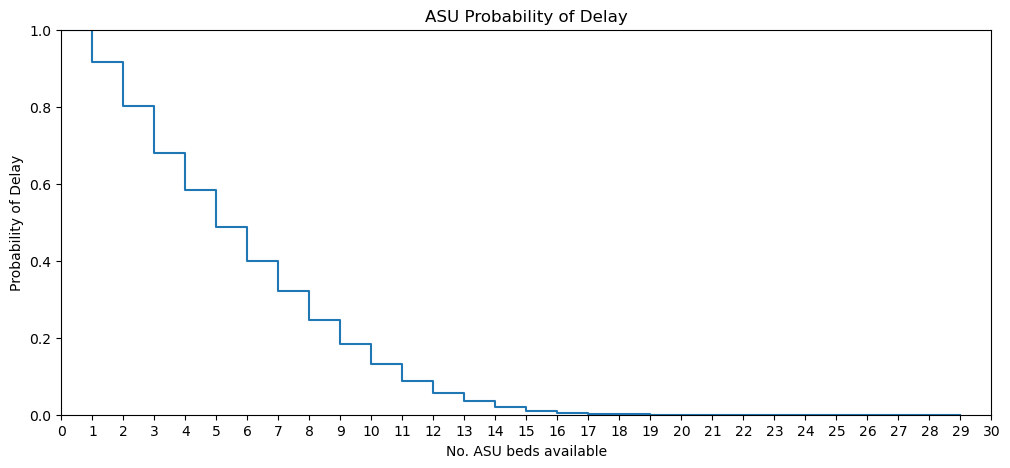

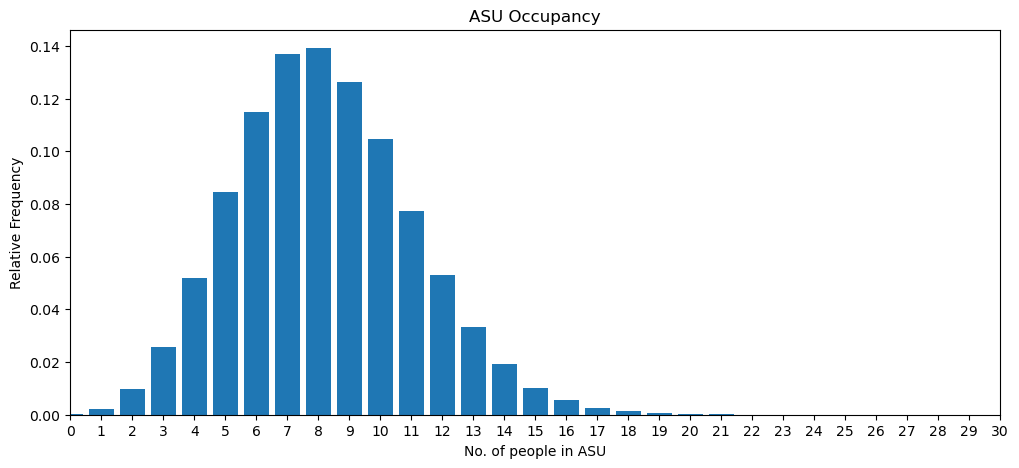

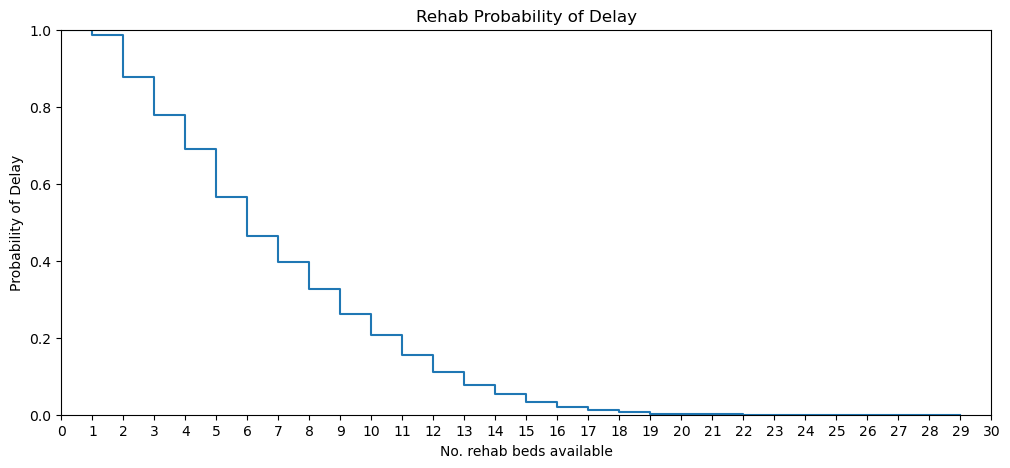

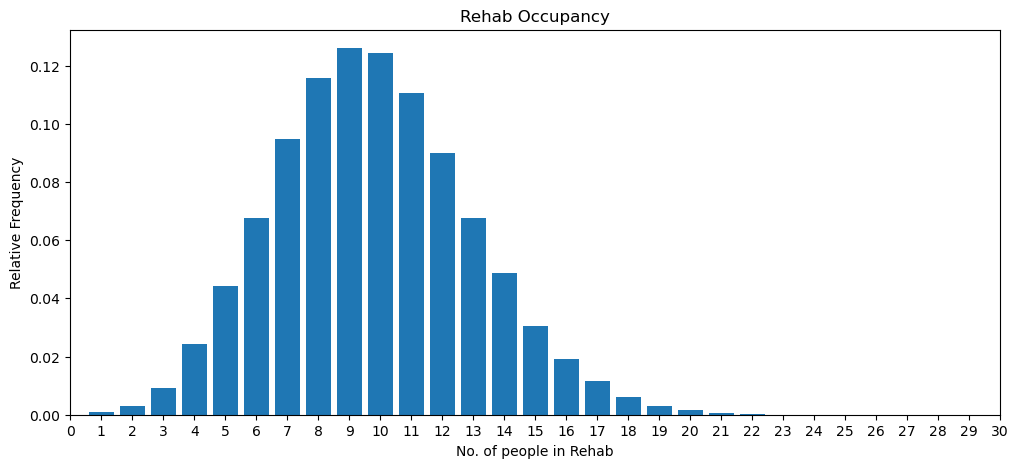

In [19]:
# Create the experiment
experiment = Experiment({
    'results_collection_period': 365*5,  # Run for 5 years
    'trace': False,  # Set to True if you want to see detailed logs
})

# Run multiple replications
rep_results = multiple_replications(experiment, num_replications=100)

# Combine results
asu_pdelay, rehab_pdelay = combine_pdelay_results(rep_results)
asu_occup, rehab_occup = combine_occup_results(rep_results)

# Calculate mean results
mean_pdelay_asu = mean_results(asu_pdelay)
mean_pdelay_rehab = mean_results(rehab_pdelay)
mean_occup_asu = mean_results(asu_occup)
mean_occup_rehab = mean_results(rehab_occup)

# Create summary tables
asu_summary = summary_table(mean_pdelay_asu, min_beds=9, max_beds=14, bed_type="ASU")
rehab_summary = summary_table(mean_pdelay_rehab, min_beds=10, max_beds=16, bed_type="Rehab")

# Plot ASU Probability of Delay
fig, ax = prob_delay_plot(mean_pdelay_asu, range(30), x_label="No. ASU beds available")
plt.title("ASU Probability of Delay")
plt.show()

# Plot ASU Occupancy
fig, ax = occupancy_plot(mean_occup_asu, range(30), x_label="No. of people in ASU")
plt.title("ASU Occupancy")
plt.show()

# Plot Rehab Probability of Delay
fig, ax = prob_delay_plot(mean_pdelay_rehab, range(30), x_label="No. rehab beds available")
plt.title("Rehab Probability of Delay")
plt.show()

# Plot Rehab Occupancy
fig, ax = occupancy_plot(mean_occup_rehab, range(30), x_label="No. of people in Rehab")
plt.title("Rehab Occupancy")
plt.show()


In [20]:
print("ASU Summary Table:")
asu_summary

ASU Summary Table:


,p(delay),1 in every n patients delayed
No. ASU beds,,
9,0.18,5
10,0.13,7
11,0.09,11
12,0.06,16
13,0.03,33
14,0.02,50


In [21]:
print("Rehab Summary Table:")
rehab_summary

Rehab Summary Table:


,p(delay),1 in every n patients delayed
No. Rehab beds,,
10,0.21,4
11,0.15,6
12,0.11,9
13,0.08,12
14,0.05,20
15,0.03,33
16,0.02,50


# Interface code 

> This code was modified in iteration 30

```python
import streamlit as st
import numpy as np
from stroke_rehab_model import (
    Experiment, multiple_replications, combine_pdelay_results,
    combine_occup_results, mean_results, prob_delay_plot,
    occupancy_plot, summary_table
)

def main():
    st.title("A Modelling Tool for Capacity Planning in Acute and Community Stroke Services")
    
    st.write("""
    This model is a recreation of the model reported in a published academic study.
    """)
    
    st.write("""
    **Citation:**
    
    Monks T, Worthington D, Allen M, Pitt M, Stein K, James MA. A modelling tool for capacity planning in acute and community stroke services. BMC Health Serv Res. 2016 Sep 29;16(1):530. doi: 10.1186/s12913-016-1789-4. PMID: 27688152; PMCID: PMC5043535.
    """)
    
    st.write("[Link to the original study](https://doi.org/10.1186/s12913-016-1789-4)")
    
    # Sidebar for input parameters
    st.sidebar.header("Set Patient Inter-arrival Rates")
    stroke_mean = st.sidebar.slider("Stroke patients", min_value=0.0, max_value=10.0, value=1.2, step=0.1)
    tia_mean = st.sidebar.slider("TIA patients", min_value=0.0, max_value=10.0, value=9.3, step=0.1)
    neuro_mean = st.sidebar.slider("Complex Neurological patients", min_value=0.0, max_value=10.0, value=3.6, step=0.1)
    other_mean = st.sidebar.slider("Other patients", min_value=0.0, max_value=10.0, value=3.2, step=0.1)
    
    st.sidebar.header("Model Control")
    trace = st.sidebar.checkbox("Trace patients in simulation", value=False)
    warm_up = st.sidebar.number_input("Warm-up period (days)", value=1095, step=1)
    
    num_replications = st.number_input("Number of Replications", value=100, min_value=1)
    
    if st.button("Simulate"):
        with st.spinner("Please wait for results..."):
            # Create the experiment
            experiment_params = {
                'results_collection_period': 365*5,
                'trace': trace,
                'warm_up': warm_up,
                'patient_types': {
                    'Stroke': {
                        'interarrival_time': stroke_mean,
                        'los_params': {'Rehab': (7.4, 8.6), 'ESD': (4.6, 4.8), 'Other': (7.0, 8.7)}
                    },
                    'TIA': {
                        'interarrival_time': tia_mean,
                        'los_params': (1.8, 5.0)
                    },
                    'Complex Neurological': {
                        'interarrival_time': neuro_mean,
                        'los_params': (4.0, 5.0)
                    },
                    'Other': {
                        'interarrival_time': other_mean,
                        'los_params': (3.8, 5.2)
                    }
                }
            }
            experiment = Experiment(experiment_params)
            
            # Run multiple replications
            rep_results = multiple_replications(experiment, num_replications=num_replications)
            
            # Combine results
            asu_pdelay, rehab_pdelay = combine_pdelay_results(rep_results)
            asu_occup, rehab_occup = combine_occup_results(rep_results)
            
            # Calculate mean results
            mean_pdelay_asu = mean_results(asu_pdelay)
            mean_pdelay_rehab = mean_results(rehab_pdelay)
            mean_occup_asu = mean_results(asu_occup)
            mean_occup_rehab = mean_results(rehab_occup)
            
            # Create summary tables
            asu_summary = summary_table(mean_pdelay_asu, min_beds=9, max_beds=14, bed_type="ASU")
            rehab_summary = summary_table(mean_pdelay_rehab, min_beds=10, max_beds=16, bed_type="Rehab")
            
            # Generate plots
            fig_pd_asu, ax_pd_asu = prob_delay_plot(mean_pdelay_asu, np.arange(0, 30))
            fig_pd_rehab, ax_pd_rehab = prob_delay_plot(mean_pdelay_rehab, np.arange(0, 30), "No. rehab beds available")
            fig_occ_asu, ax_occ_asu = occupancy_plot(mean_occup_asu, np.arange(0, 30))
            fig_occ_rehab, ax_occ_rehab = occupancy_plot(mean_occup_rehab, np.arange(0, 30), "No. people in rehab")
        
        # Display results
        st.subheader("Acute Stroke Unit Results")
        st.table(asu_summary)
        
        st.subheader("Rehabilitation Unit Results")
        st.table(rehab_summary)
        
        st.subheader("Probability Delay Plots")
        st.pyplot(fig_pd_asu)
        st.pyplot(fig_pd_rehab)
        
        st.subheader("Occupancy Plots")
        st.pyplot(fig_occ_asu)
        st.pyplot(fig_occ_rehab)

if __name__ == "__main__":
    main()


```

## Testing <a class="anchor" id="testing_code"></a>
* **Results processing 1**: code correctly calculates relative and cumulative frequencies
    * Expected result: for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
    * Actual result (PASS): for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
* **Results processing 2**: test that prob delay is calculated correctly.
    * Expected result: The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
    * Actual result (PASS): The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
* **Results collection test 1**: Test the result collection process for ASU collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 2**: Test ASU ward occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range 0 to 50 with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are in the range 0 to 50 with sensible moments.
* **Results collection test 3**: Test the result collection process for REHAB collects unit occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 4**: Test REHAB unit occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range 0 to (10-15) with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are 0 to (10-15) with sensible moments.
* **Results collection test 5**: **SYSTEM TEST**: Test the result collection process for ASU+REHAB collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Single run test**: **SYSTEM TEST**: Test that the `single_run` function returns a dictionary of results
  * Expected Result: len(run_results) == 6 and type(run_results) == dict
  * Actual Result (PASS): len(run_results) == 6 and type(run_results) == dict
* **Random number set test 1 (ASU)**: Test that ASU results are repeated each time the same random number set is used.
    * Expected Result: min, max, and mean occupancy is identical when model is run twice with same random numbers
    * Actual Result (PASS): min, max, and mean occupancy is identical when model is run twice with same random numbers
* **Random number set test 2 (SYSTEM TEST)**: Test that ASU+REHAB results are repeated each time the same random number set is used.
    * Expected Result: min, max, and mean occupancy is identical when model is run twice with same random numbers
    * Actual Result (PASS): min, max, and mean occupancy is identical when model is run twice with same random numbers
* **Warm-up Period Test**: Test warm-up works correctly for ASU+REHAB ward occupancy. Audit interval = 1 and Warm-up > 0
    * Expected result: The length of the occupancy data collection arrays is equal to the results collection period.
    * Actual result (PASS): The length of the occupancy data collection arrays is equal to the results collection period.
* **Suppress simulated trace**: Test that setting experiment.trace = False suppresses ASU output by default.
    * Expected result: The ASU model runs with no simulated log output
    * Actual result (PASS): The ASU model runs with no simulated log output
* **Suppress simulated trace 2**: Test that setting experiment.trace = False suppresses REHAB output by default.
    * Expected result: The REHAB model runs with no simulated log output
    * Actual result (PASS): The REHAB model runs with no simulated log output
* **Testing lognormal function**: Test that lognomal function correctly calculates the moments of the underlying normal dist.
    * Expected result: The LLM generated function and `sim-tools.distributions.Lognormal` perform the same conversion.
    * Actual results (PASS):  The functions generate the same values.
* **Extreme value test 1**: TIA, Complex Neuro, Other, have their inter-arrival time is set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the model is "Stroke"
* **Extreme value test 2**: All patient types have have their inter-arrival time is set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Different run length**: The run length of the model is set to 10 days.
    * Expected result: The model should runs no longer than 10 simulated time periods
    * Actual result (PASS): The model runs no longer than 10 simulated time periods
* **Extreme value test 3**: All patient types have have their mean length of stay time set to $M$ a very large number
    * Expected result: No patients depart the model (only arrivals seen in log)
    * Actual Results (PASS): No patients depart the model.
* **Extreme value test 4**: All patient types apart from stroke->rehab have have their mean length of stay time set to $M$ a very large number
    * Expected result: Only stroke patients depart the model (seen in log)
    * Actual Results (PASS): Only stroke patient depart the model.
* **Extreme value test 5**: In rehab, Complex Neuro, and Other, have their inter-arrival time is set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the rehab model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the rehab model is "Stroke"
* **Extreme value test 6**: In the rehab model, all patient types have have their inter-arrival time is set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Extreme value test 7**: In the rehab model, all patient types have their length of stay means set to $M$ a very larger number.
    * Expected result: Patients arrive to the model as normal, but do not depart.
    * Actual result (PASS): Patients arrive to the model as normal, but do not depart.

### Results processing 1

Test that the code correctly calculates the relative and cumulative frequencies of a python list of integer values.

(PASS)

In [23]:
def result_processing_test_1(values, rel_expected, cum_expected):
    '''
    Test the `calculate_occupancy_frequencies` function works
    as expected.

    Expected result: relative frequencies and cumulative freqs
    are the same as expected values.

    Params:
    ------
    values: list
        list of values to test

    rel_expected: list
        list of floats - expected relative freqs

    cum_expected: list
        list of floats - expected cumulative freqs

    Returns:
    -------
    bool: does the model pass the test.
    '''
    rel, cum, unique = calculate_occupancy_frequencies(values)
    # use all close to allow for minor floating point differences.
    return (set(rel) == set(rel_expected)) and  np.allclose(np.array(cum_expected), cum)

In [24]:
result_processing_test_1(values=[1, 1, 1, 1, 2, 2, 2, 3, 3, 4],
                         rel_expected=[0.4, 0.3, 0.2, 0.1],
                         cum_expected=[0.4, 0.7, 0.9, 1.0])

True

### Results Processing test 2

Test that the calculation of the probability of delay is correct.

(PASS)

In [25]:
def result_processing_test_2(relative, cum, p_delay_expected):
    '''
    Test the probability of delay is calculated correctly.
    
    Params:
    ------
    relative: list
        list of floats - relative freqs

    cum: list
        list of floats - cumulative freqs

    Returns:
    -------
    bool: does the function pass the test.
    '''
    p_delay = calculate_prob_delay(relative, cum)
    # use all close to allow for minor floating point differences.
    return np.allclose(np.array(p_delay_expected), p_delay)

In [26]:
relative = [0.4, 0.3, 0.2, 0.1],
cum = [0.4, 0.7, 0.9, 1.0]
expected = [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
result = result_processing_test_2(relative, cum, expected)
result

True

### Results collection test 1

Test the optional results collection process works correctly.  The process should collect acute stroke occupancy every day

(PASS)

In [27]:
def results_collection_test1(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: len(experiment.occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arr~ival rates
    default_experiment_params = Experiment()

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    # MODIFIED iter 21
    env.process(audit_acute_occupancy(env, 1, audit_interval, acu_experiment, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    print(f'{len(default_experiment_params.asu_occupancy)=}')
    print(f'{env.now=}')
    return len(default_experiment_params.asu_occupancy) == (env.now - 1)

In [28]:
results_collection_test1()

len(default_experiment_params.asu_occupancy)=1824
env.now=1825


True

### Result collection test 2

(PASS)

In [29]:
def results_collection_test2(audit_interval=1):
    '''
    Test ASU ward occupancy data collected is in a sensible range.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 0 to 50 with sensible moments.

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    None
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arr~ival rates
    default_experiment_params = Experiment()

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    # MODIFIED iter 21
    env.process(audit_acute_occupancy(env, 1, audit_interval, acu_experiment, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    print(f'{min(default_experiment_params.asu_occupancy)=}')
    print(f'{max(default_experiment_params.asu_occupancy)=}')
    print(f'{statistics.fmean(default_experiment_params.asu_occupancy)=}')
    print([round(q, 1) for q in statistics.quantiles(default_experiment_params.asu_occupancy, n=10)])

In [30]:
results_collection_test2()

min(default_experiment_params.asu_occupancy)=1
max(default_experiment_params.asu_occupancy)=21
statistics.fmean(default_experiment_params.asu_occupancy)=8.296600877192983
[5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]


### Results collection test 3

Test the optional results collection process works correctly for rehab.  The process should collect rehab unit occupancy every day.

(PASS)


In [31]:
def results_collection_test3(audit_interval=1):
    '''
    Test the model collects rehab occupancy every day

    Expected result: len(experiment.rehab_occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()

    # create experiment
    default_experiment = Experiment()
    
    rehab_unit = RehabilitationUnit(env, default_experiment)

    # Initialise the patient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
    
    # Initialise the audit of rehab occupancy as a simpy process with an interval of 1 day
    # MODIFIED iter 12
    env.process(audit_rehab_occupancy(env, 1, audit_interval, rehab_unit, default_experiment))
    
    # Run the model for the default run length in the experiment
    # MODIFIED iter 12
    env.run(until=default_experiment.results_collection_period)
    print(f'{len(default_experiment.rehab_occupancy)=}')
    print(f'{env.now=}')
    return len(default_experiment.rehab_occupancy) == (env.now - 1)

In [32]:
results_collection_test3()

len(default_experiment.rehab_occupancy)=1824
env.now=1825


True

### Results Collection Test 4

(PASS)

In [33]:
def results_collection_test4(audit_interval=1):
    '''
    Test REHAB ward occupancy data collected is in a sensible range.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 1 to [10-15] with sensible moments.

    Note this is when the Rehab unit is used independently
    with external arrivals only i.e. no transfers from ASU.

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    None
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # create experiment
    default_experiment = Experiment()
    
    rehab_unit = RehabilitationUnit(env, default_experiment)

    # Initialise the patient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
    
    # Initialise the audit of rehab occupancy as a simpy process with an interval of 1 day
    # MODIFIED iter 12
    env.process(audit_rehab_occupancy(env, 1, audit_interval, rehab_unit, default_experiment))
    
    # Run the model for the default run length in the experiment
    # MODIFIED iter 12
    env.run(until=default_experiment.results_collection_period)
    
    print(f'{min(default_experiment.rehab_occupancy)=}')
    print(f'{max(default_experiment.rehab_occupancy)=}')
    print(f'{statistics.fmean(default_experiment.rehab_occupancy)=}')
    print([round(q, 1) for q in statistics.quantiles(default_experiment.rehab_occupancy, n=10)])

In [34]:
results_collection_test4()

min(default_experiment.rehab_occupancy)=0
max(default_experiment.rehab_occupancy)=8
statistics.fmean(default_experiment.rehab_occupancy)=2.633771929824561
[1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 5.0]


### Results Collection Test 5 (SYSTEM TEST)

Test that when the models are linked that the occupancy is audited correctly.

In [35]:
def results_collection_test5(audit_interval=1):
    '''
    Test REHAB ward occupancy data collected is in a sensible range
    when it is connected to the ASU model.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 1 to [10-15] with sensible moments.

    Expected result: 
        len(experiment.asu_occupancy) == env.now - 1 AND
        len(experiment.rehab_occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # a default experiment
    default_experiment_params = Experiment()

    # create models
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # Initialize the pREHAB atient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())  

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    # MODIFIED iter 12
    env.process(audit_acute_occupancy(env, 1, audit_interval, acu_experiment, default_experiment_params))

    # Initialize the audit of rehab occupancy as a simpy process with an interval of 1 day
    # MODIFIED iter 12
    env.process(audit_rehab_occupancy(env, 1, audit_interval, rehab_unit, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period)

    # print info for debug
    print(f'{len(default_experiment_params.asu_occupancy)=}')
    print(f'{len(default_experiment_params.rehab_occupancy)=}')
    print(f'{env.now=}')

    # test
    return len(default_experiment_params.asu_occupancy) == (env.now - 1) and \
        len(default_experiment_params.rehab_occupancy) == (env.now - 1)

In [36]:
results_collection_test5()

len(default_experiment_params.asu_occupancy)=1824
len(default_experiment_params.rehab_occupancy)=1824
env.now=1825


True

### Results Collection Test 6 (SYSTEM TEST)


In [37]:
def results_collection_test6(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: The type collected is int. The values are in 
    the range in the range 1 to ~25 with sensible moments.

    Note this is when the Rehab unit is linked to the ASU.
    I.e. transfers from ASU + external arrivals

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # a default experiment
    default_experiment_params = Experiment()

    # create models
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # Initialize the pREHAB atient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())  

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    # MODIFIED iter 12
    env.process(audit_acute_occupancy(env, 1, audit_interval, acu_experiment, default_experiment_params))

    # Initialize the audit of rehab occupancy as a simpy process with an interval of 1 day
    # MODIFIED iter 12
    env.process(audit_rehab_occupancy(env, 1, audit_interval, rehab_unit, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period * 10)

    # test
    print(f'{min(default_experiment_params.rehab_occupancy)=}')
    print(f'{max(default_experiment_params.rehab_occupancy)=}')
    print(f'{statistics.fmean(default_experiment_params.rehab_occupancy)=}')
    print([round(q, 1) for q in statistics.quantiles(default_experiment_params.rehab_occupancy, n=10)])

In [38]:
results_collection_test6()

min(default_experiment_params.rehab_occupancy)=0
max(default_experiment_params.rehab_occupancy)=21
statistics.fmean(default_experiment_params.rehab_occupancy)=9.399145158638829
[6.0, 7.0, 8.0, 9.0, 9.0, 10.0, 11.0, 12.0, 13.0]


### Warm-up Test

(PASS)

In [39]:
def warm_up_test(warm_up, audit_interval=1):
    '''
    Test warm-up works correctly for ASU+REHAB ward occupancy

    Expected result: 
        len(experiment.asu_occupancy) == experiment.results_collection_period 
        AND len(experiment.rehab_occupancy) == experiment.results_collection_period 

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # a default experiment
    default_experiment_params = Experiment(warm_up=warm_up)

    # create models
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # Initialize the pREHAB atient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())  

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    env.process(audit_acute_occupancy(env, warm_up, audit_interval, acu_experiment, default_experiment_params))

    # Initialize the audit of rehab occupancy as a simpy process with an interval of 1 day
    env.process(audit_rehab_occupancy(env, warm_up, audit_interval, rehab_unit, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    env.run(until=default_experiment_params.warm_up + default_experiment_params.results_collection_period)

    # print info for debug
    print(f'{len(default_experiment_params.asu_occupancy)=}')
    print(f'{len(default_experiment_params.rehab_occupancy)=}')
    print(f'{env.now=}')
    print(f'{default_experiment_params.results_collection_period=}')
    print(f'{default_experiment_params.warm_up + default_experiment_params.results_collection_period=}')

    # test
    return len(default_experiment_params.asu_occupancy) == (default_experiment_params.results_collection_period) and \
        len(default_experiment_params.rehab_occupancy) == (default_experiment_params.results_collection_period) 

In [40]:
warm_up_test(warm_up=365)

len(default_experiment_params.asu_occupancy)=1825
len(default_experiment_params.rehab_occupancy)=1825
env.now=2190
default_experiment_params.results_collection_period=1825
default_experiment_params.warm_up + default_experiment_params.results_collection_period=2190


True

### Single run test (SYSTEM TEST)

In [41]:
def single_run_test():
    '''
    Test the the single_run function returns a dictionary of 
    results.

    The results dictionary contains the following keys:

    'relative_freq_asu'
    'prob_delay_asu'
    'unique_vals_asu'
    'relative_freq_rehab'
    'prob_delay_rehab'
    'unique_vals_rehab'

    Expected result: 
        len(run_results) == 6 and type(run_results) == dict

    Returns:
    -------
    bool: does the model pass the test.
    '''

    # a default experiment
    default_experiment_params = Experiment()

    # run the model
    run_results = single_run(default_experiment_params)

    print(f"{run_results['relative_freq_asu']=}")
    
    # test
    return len(run_results) == 6 and type(run_results) == dict

In [42]:
single_run_test()

run_results['relative_freq_asu']=array([0.00109589, 0.00876712, 0.02849315, 0.04712329, 0.08      ,
       0.12547945, 0.13150685, 0.14027397, 0.12876712, 0.09369863,
       0.07342466, 0.06136986, 0.03835616, 0.01863014, 0.00931507,
       0.00438356, 0.00273973, 0.00273973, 0.00219178, 0.00109589,
       0.00054795])


True

### Random number set test (ASU only)

Test that ASU results are repeated each time the same random number set is used.


In [43]:
def random_number_set_test1(random_number_set, print_output=True):
    '''
    Test the the ASU model produces repeatable results. 

    Compares
    min, max, mean of occupancy.
    
    Expected result: 
        set(run1) == set(run2)

    Returns:
    -------
    bool: does the model pass the test.
    '''

    results = []

    for i in range(2):
        
        # Create the simulation environment
        env = simpy.Environment()
        
        # Initialize the Acute Stroke Unit model#
        # set ASU arr~ival rates
        experiment = Experiment(random_number_set=random_number_set)
    
        # modified iteration 19. 
        # add RU, but do not run the model
        rehab_unit = RehabilitationUnit(env, experiment)
        
        asu = AcuteStrokeUnit(env, experiment, rehab_unit)
        
        # Start the patient generators for each type of patient
        env.process(asu.stroke_patient_generator())
        env.process(asu.tia_patient_generator())
        env.process(asu.neuro_patient_generator())
        env.process(asu.other_patient_generator())
    
        # optional results collection
        # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
        env.process(audit_acute_occupancy(env, 1, 1, asu, experiment))
        
        # Run the simulation until the specified run length in the Experiment parameters
        env.run(until=experiment.results_collection_period)

        if print_output: 
            print(f'Run {i} results:')
            print(f'{min(experiment.asu_occupancy)=}')
            print(f'{max(experiment.asu_occupancy)=}')
            print(f'{statistics.fmean(experiment.asu_occupancy)=}')
            print([round(q, 1) for q in statistics.quantiles(experiment.asu_occupancy, n=10)])

        results.append(set((min(experiment.asu_occupancy), 
                            max(experiment.asu_occupancy),
                            statistics.fmean(experiment.asu_occupancy))))
    
    # test
    return results[0] == results[1]

In [44]:
random_number_set_test1(0)

Run 0 results:
min(experiment.asu_occupancy)=1
max(experiment.asu_occupancy)=21
statistics.fmean(experiment.asu_occupancy)=8.296600877192983
[5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
Run 1 results:
min(experiment.asu_occupancy)=1
max(experiment.asu_occupancy)=21
statistics.fmean(experiment.asu_occupancy)=8.296600877192983
[5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]


True

In [45]:
# run for many random seeds.
results = [random_number_set_test1(i, False) for i in range(10)]
results

[True, True, True, True, True, True, True, True, True, True]

### Random number set test 2 (SYSTEM TEST)

PASS

In [46]:
def random_number_set_test2(random_number_set, print_output=True):
    '''
    Test the the single_run function returns a dictionary of 
    results.

    The results dictionary contains the following keys:

    'relative_freq_asu'
    'prob_delay_asu'
    'unique_vals_asu'
    'relative_freq_rehab'
    'prob_delay_rehab'
    'unique_vals_rehab'

    Expected result: 
        len(run_results) == 6 and type(run_results) == dict

    Returns:
    -------
    bool: does the model pass the test.
    '''
    
    results = []
    for i in range(2):
    
        # set a random number set for streams
        experiment = Experiment(random_number_set=random_number_set)
    
        # run the model
        run_results = single_run(experiment)

        if print_output: 
            print(f'Run {i} results:')
            print(f'{min(experiment.asu_occupancy)=}')
            print(f'{max(experiment.asu_occupancy)=}')
            print(f'{statistics.fmean(experiment.asu_occupancy)=}')
            print([round(q, 1) for q in statistics.quantiles(experiment.asu_occupancy, n=10)])

        results.append(set((min(experiment.asu_occupancy), 
                            max(experiment.asu_occupancy),
                            statistics.fmean(experiment.asu_occupancy))))
    
    # test
    return results[0] == results[1]

In [47]:
# run for many random seeds.
results = [random_number_set_test2(i, False) for i in range(10)]
results

[True, True, True, True, True, True, True, True, True, True]

### Test suppress trace 1

(PASS)

In [48]:
def test_suppress_log(trace):
    '''
    Test that setting experiment.trace 
    False suppresses output.

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arr~ival rates
    default_experiment_params = Experiment(
        trace=trace,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period)

    return acu_experiment.patient_count

In [49]:
test_suppress_log(trace=False)

2821

### Test suppress trace 2

In [50]:
def test_suppress_log_rehab(trace):
    '''
    Test that setting experiment.trace to
    False suppresses output in the rehab model

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''
    # Create the simulation environment
    env = simpy.Environment()

    # create experiment
    default_experiment_params = Experiment(

        trace=trace,   
    )

    # this will be need to be modified in subsequent iterations
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient in the instance
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
        
    # Run the simulation until the specified run length
    env.run(until=100)

    # print out stats collected
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    print(f'{rehab_unit.occupancy=}')
    return rehab_unit.patient_count

In [51]:
test_suppress_log_rehab(False)

rehab_unit.patient_count=8
rehab_unit.stroke_count=4
rehab_unit.neuro_count=1
rehab_unit.other_count=3
rehab_unit.occupancy=0


8

### Lognormal test

Test that lognomal function correctly calculates the moments of the underlying normal dist.

**Result: PASS**

In [52]:
def test_lognormal_moments(mean, std):
    '''
    Test that lognomal function correctly calculates 
    the moments of the underlying normal dist.

    Params:
    ------
    mean: float
        mean of the lognormal distribution

    std: float
        st dev of the lognormal distribution

    Returns:
    -------
    bool
    '''
   
    # Lognormal class from sim-tools.
    expected_moments = Lognormal(mean, std)
    print(expected_moments.mu, expected_moments.sigma)
    
    ## llm code
    llm_mu, llm_sigma = normal_moments_from_lognormal(mean, std)
    print(llm_mu, llm_sigma)
    
    return (llm_mu, llm_sigma) == (expected_moments.mu, expected_moments.sigma)

In [53]:
test_lognormal_moments(128.79, 267.51)

4.022977459259615 1.2924439729790718
4.022977459259615 1.2924439729790718


True

### Extreme value test 1

The model uses hard coded parameters.  The most simple way to modify the code for this test was to change hard coded parameters for $M$

**Result: PASS**

In [54]:
M = 10_000_000

In [55]:
def ev_test_1(large_number):
    '''
    TIA, Complex Neuro, Other, have their inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the model 
    is "Stroke". This is seen in the event log

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        tia_mean=large_number,
        neuro_mean=large_number,
        other_mean=large_number,
        trace=True,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period)

    return acu_experiment.patient_count

In [56]:
ev_test_1(M)

Stroke patient 1 arrived at 0.03448962093012004 days and will go to Rehab
Stroke patient 2 arrived at 0.4406268799281962 days and will go to Rehab
Stroke patient 3 arrived at 0.6509676624994637 days and will go to Other
Stroke patient 4 arrived at 1.2314453050357161 days and will go to Other
Stroke patient 5 arrived at 1.7226581551516447 days and will go to Rehab
Stroke patient 6 arrived at 2.033109034369018 days and will go to Other
Stroke patient 6 finished treatment at 2.7931678527037325 days
Stroke patient 7 arrived at 3.668084847597135 days and will go to ESD
Stroke patient 7 finished treatment at 4.752089497603478 days
Stroke patient 8 arrived at 4.979194982801859 days and will go to Other
Stroke patient 8 finished treatment at 5.28654643841973 days
Stroke patient 8 finished treatment at 5.892784326292063 days
Stroke patient 9 arrived at 6.0023654986365615 days and will go to ESD
Stroke patient 9 finished treatment at 6.9960004544124885 days
Stroke patient 9 finished treatment at

1525

### Extreme value test 2

* An experiment is setup so that all patient types have a mean inter-arrival rate of $M$

**Result: PASS**

In [57]:
def ev_test_2(large_number):
    '''
    All patient types have have their inter-arrival time is 
    set to $M$ a very large number
    
    Expected result: No patients arrive to the model.
    
    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        stroke_mean=large_number,
        tia_mean=large_number,
        neuro_mean=large_number,
        other_mean=large_number,
        trace=False,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period)

    return acu_experiment.patient_count

In [58]:
ev_test_2(M)

0

### Different run length test

The model has again been modified to use the original code and parameters generated by the LLM.

In [59]:
TEN_DAYS = 10

In [60]:
def test_run_length(run_length):
    '''
    Test that the run length of the model can be modified.
    
    Expected result: The model should runs no longer than the new run length.

    Params:
    ------
    run_length: float
        Run length of the model in days.

    Returns:
    -------
    float
        Simulation end time.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    # MODIFIED iter 21
    default_experiment_params = Experiment(
        results_collection_period=run_length,
        trace=False,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    return env.now

In [61]:
test_run_length(TEN_DAYS)

10

### Extreme value test 3

* An experiment is setup so that all patient types have a mean length of stay on the ASU of $M$

**Result: PASS**

In [62]:
def ev_test_3(large_number):
    '''
    All patient types have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: No patients depart the model 
    The number of arrivals = the occupancy of the model.

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        rehab_mean=M,  # stroke->rehab
        esd_mean=M,    # stroke-> ESD
        other_dest_mean=M, # stroke->other
        tia_dest_mean=M,   # TIA patients
        neuro_dest_mean=M, # complex neuro patients
        other_dest_mean_2=M, # other (med outlier) patients
        trace=False,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    print(f'{acu_experiment.patient_count=}')
    print(f'{acu_experiment.occupancy=}')
    
    return acu_experiment.patient_count == acu_experiment.occupancy 

In [63]:
result = ev_test_3(M)

acu_experiment.patient_count=2821
acu_experiment.occupancy=2821


In [64]:
result

True

### Extreme value test 4

* An experiment is setup so that all patient types other than stroke->rehab have a mean length of stay on the ASU of $M$

**Result: PASS**

In [65]:
def ev_test_4(large_number):
    '''
    All patient types apart from stroke-rehab patients
    have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: Only stroke patients depart the
    model.
    (assed by viewing  log and patient_count > occupancy)

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        rehab_mean=7.4,  # stroke->rehab
        esd_mean=M,    # stroke-> ESD
        other_dest_mean=M, # stroke->other
        tia_dest_mean=M,   # TIA patients
        neuro_dest_mean=M, # complex neuro patients
        other_dest_mean_2=M, # other (med outlier) patients
        trace=False,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    print(f'{acu_experiment.patient_count=}')
    print(f'{acu_experiment.occupancy=}')
    
    return acu_experiment.patient_count > acu_experiment.occupancy

In [66]:
results = ev_test_4(M)

acu_experiment.patient_count=2821
acu_experiment.occupancy=2473


In [67]:
results

True

### Extreme value test 5

Only stroke arrivals to the Rehab unit

(PASS)

In [68]:
def ev_test_5(large_number):
    '''
    Complex Neuro, Other, have their rehab inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the rehab model 
    is "Stroke". This is verified by the patient counts variables in the model.

    Notes:
    ------
    This test will need to be modified when the hardcoded parameters
    are migrated to the Experiment class. 

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool: rehab_unit.stroke_count == rehab_unit.patient_count
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # set Rehab arrival rates
    default_experiment_params = Experiment(
        rehab_neuro_iat = large_number,
        rehab_other_iat = large_number,
    )
    
    # this will be need to be modified in subsequent iterations
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
        
    # Start the patient generators for each type of patient in the RehabilitationUnit instance
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
        
    # Run the simulation until the specified run length
    env.run(until=1825)

    # print out stats collected
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    
    return rehab_unit.stroke_count == rehab_unit.patient_count

In [69]:
ev_test_5(M)

rehab_unit.patient_count=89
rehab_unit.stroke_count=89
rehab_unit.neuro_count=0
rehab_unit.other_count=0


True

### Extreme Value test 6

No arrivals to the rehab unit.

(PASS)

In [70]:
def ev_test_6(large_number):
    '''
    All patient types have their REHAN inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: No patients arrive to the model
    This is verified by the patient count variables in the model.

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool:rehab_unit.patient_count == 0
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # set Rehab arrival rates
    default_experiment_params = Experiment(
        rehab_stroke_iat = large_number,
        rehab_neuro_iat = large_number,
        rehab_other_iat = large_number,
    )
    
    # this will be need to be modified in subsequent iterations
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient in the RehabilitationUnit instance
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
        
    # Run the simulation until the specified run length
    env.run(until=1825)

    # print out stats collected
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    print(f'{rehab_unit.occupancy=}')
    
    return rehab_unit.patient_count == 0

In [71]:
ev_test_6(M)

rehab_unit.patient_count=0
rehab_unit.stroke_count=0
rehab_unit.neuro_count=0
rehab_unit.other_count=0
rehab_unit.occupancy=0


True

### Extreme value test 7

In the rehab model, all patient types have their length of stay means set to $M$ a very larger number.

(PASS)

In [72]:
def ev_test_7(large_number):
    '''
    All patient types have have their mean length 
    of stay time in REHAB set to $M$ a very large number
    
    Expected result: No patients depart the rehab model 
    The occupancy of the model is equal to the no. patient arrivals
    
    Notes:
    -----
    This test will also need to be modified when TIA treatment is added
    and tested when working in connection with the ASU.

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        rehab_stroke_esd_mean=large_number, # stroke->ESD
        rehab_stroke_other_mean=large_number, # stroke->other
        rehab_neuro_mean=large_number, # complex neuro
        rehab_other_mean=large_number, # other patients.
        trace=False,   
    )

    # this will be need to be modified in subsequent iterations
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient in the instance
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
        
    # Run the simulation until the specified run length
    env.run(until=100)

    # print out stats collected
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    print(f'{rehab_unit.occupancy=}')
    
    return rehab_unit.patient_count == rehab_unit.occupancy

In [73]:
ev_test_7(M)

rehab_unit.patient_count=8
rehab_unit.stroke_count=4
rehab_unit.neuro_count=1
rehab_unit.other_count=3
rehab_unit.occupancy=8


True

### Extreme value test 8 (SYSTEM TEST)

Set all inter-arrival times - asu and rehab to $M$. Where $M$ is a very large number.

In [74]:
def ev_test_8(large_number):
    '''
    All patient types have their AUS and REHAB inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: No patients arrive to the model
    This is verified by the patient count variables in the model.

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool:rehab_unit.patient_count == 0 and asu.patient_count == 0
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # set Rehab arrival rates
    default_experiment_params = Experiment(
        stroke_mean=large_number,
        tia_mean=large_number,
        neuro_mean=large_number,
        other_mean=large_number,
        rehab_stroke_iat = large_number,
        rehab_neuro_iat = large_number,
        rehab_other_iat = large_number,
    )
    
    # create models
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # Initialize the pREHAB atient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())  

    # no optional data collection needed in this test
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    # print out stats collected
    print(f'{acu_experiment.patient_count=}')
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    print(f'{rehab_unit.occupancy=}')
    
    return rehab_unit.patient_count == 0 and acu_experiment.patient_count== 0

In [75]:
ev_test_8(M)

acu_experiment.patient_count=0
rehab_unit.patient_count=0
rehab_unit.stroke_count=0
rehab_unit.neuro_count=0
rehab_unit.other_count=0
rehab_unit.occupancy=0


True